# Testing Model Serialization

In [1]:
import os
import warnings
import cv2
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from google.cloud import storage
import pickle

%matplotlib inline
style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

In [36]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

In [4]:
def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32') # Converting image array from dtype uint8 to float32
    X_data = np.stack((X_data,)*3, axis=-1) # because images are B&W, NumPy arrays have only one channel, not three
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data) #Converts a class vector to a binary class matrix for use with categorical crossentropy
    return X_data, y_data

In [5]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

In [6]:
def walk_file_tree(relative_path):
    X_data = []
    y_data = []
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and (not file.startswith('C_')):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

In [3]:
gestures = {'L_': 'L',
           'fi': 'Fist',
           'C_': 'C',
           'ok': 'Okay',
           'pe': 'Peace',
           'pa': 'Palm'
            }

gestures_map = {'Fist' : 0,
                'L': 1,
                'Okay': 2,
                'Palm': 3,
                'Peace': 4
                }

In [7]:
relative_path = 'silhouettes'
rgb = False

# # This method processes the data
X_data_sil, y_data_sil = walk_file_tree(relative_path)

In [6]:
with open('X_data.pkl', 'rb') as f:
    X_data_sil = pickle.load(f)

In [7]:
with open('y_data.pkl', 'rb') as f:
    y_data_sil = pickle.load(f)

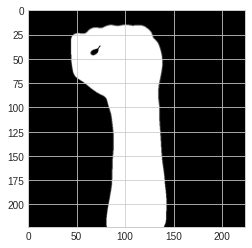

In [16]:
plt.imshow(X_data_sil[0])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_data_sil, y_data_sil, test_size = 0.9, random_state=42, stratify=y_data_sil)

In [33]:
imageSize = 224

vgg_base = tf.keras.applications.VGG16(weights ='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                 include_top=False,
                 input_shape=(imageSize, imageSize, 3)) # Image is 224x224 pixels and 3 channels

#Adam optimiser to reach to the global minima while training out model.
# If I am stuck in local minima while training then the adam optimiser 
# will help us to get out of local minima and reach global minima.

base_model = vgg_base #topless

# Add top layer
x = base_model.output # research further
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dense(128, activation='relu', name='fc2')(x)
x = tf.keras.layers.Dense(128, activation='relu', name='fc3')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu', name='fc4')(x)

predictions = tf.keras.layers.Dense(5, activation='softmax')(x) # research further

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Train top layers only
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,
          y_train,
          epochs = 1,
          batch_size=64,
          validation_data=(X_train, y_train),
          verbose =1)

Train on 274 samples, validate on 274 samples
274/274 [==============================] - 20s 75ms/sample - loss: 1.7259 - accuracy: 0.2409 - val_loss: 1.4339 - val_accuracy: 0.3905


In [34]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 36.34%


### Serializing Model

In [25]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [26]:
# load json and create model
json_file = open('model.json', 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

In [28]:
loaded_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 41.23%


In [37]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     